In [151]:
from __future__ import division, print_function
import glob
import os
import cv2
import PIL
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from Utils import cv2_scale36, cv2_scale, np_reshape, np_reshape64
from scipy.optimize import linear_sum_assignment

In [152]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [153]:
p_features = torch.load("p_description.pth")
q_features = torch.load("q_description.pth")
print(p_features.shape)
print(q_features.shape)

torch.Size([5, 50, 128])
torch.Size([5, 50, 128])


In [154]:
def getCost_one2one(des1, des2, kps_num=50):
    des1 = des1.view(kps_num, 1, 128).expand(kps_num, kps_num, 128).contiguous().view(kps_num*kps_num, 128)
    des2 = des2.view(1, kps_num, 128).expand(kps_num, kps_num, 128).contiguous().view(kps_num*kps_num, 128)
    
    simi = (1 + F.cosine_similarity(des1, des2))/2
    simi = simi.view(kps_num, kps_num)
    cost = 1 - simi
    row_ind, col_ind = linear_sum_assignment(cost.cpu().detach().numpy())
    
    return simi[row_ind, col_ind].sum()

In [155]:
features = torch.cat((p_features, q_features), 0)
query_num = 5
image_num = 5
similarity_one2one = torch.zeros(query_num, image_num)
for idx in range(query_num):
    print("finished No.{} query".format(idx+1))
    for jdx in range(image_num):
        similarity_one2one[idx,jdx] = getCost_one2one(features[idx], features[jdx+query_num])

finished No.1 query
finished No.2 query
finished No.3 query
finished No.4 query
finished No.5 query


In [156]:
p_kps = torch.load("p_keypints.pth")
q_kps = torch.load("q_keypints.pth")
fundamental = torch.zeros(5,2,3,3)
for idx in range(5):
    print("finished No.{} query".format(idx+1))
    for idy in range(5):
        f1, mask1 = cv2.findFundamentalMat(np.array(p_kps[idx]), np.array(q_kps[idy]), cv2.FM_8POINT, 3, 0.99)
        f2, mask2 = cv2.findFundamentalMat(np.array(p_kps[idx]), np.array(q_kps[idy]), cv2.FM_RANSAC, 3, 0.99)
        fundamental[idx,0] = torch.from_numpy(f1)
        fundamental[idx,1] = torch.from_numpy(f2)

finished No.1 query
finished No.2 query
finished No.3 query
finished No.4 query
finished No.5 query


In [157]:
f3 = torch.load("F2.pt")
f3 = f3.view(5,1,3,3)

In [158]:
fundamental = torch.cat((fundamental, f3), 1)
fundamental.shape

torch.Size([5, 3, 3, 3])

In [139]:
p11 = [[81,123], [594,409], [848,504], [167,212], [983,300], [146,581], [57,482],   [242,494], [213,56], [944,639] ]
p12 = [[126,131],[609,412], [857,508], [200,216], [1017,302],[177,579], [97,480],   [268,494], [251,63], [966,647] ]
p21 = [[95,303], [309,433], [36,176],  [419,192], [623,451], [575,224], [157,176],  [73,536],  [398,75], [229,145] ]
p22 = [[118,302],[318,433], [70,175],  [451,191], [639,450], [605,223], [192,175],  [72,536],  [418,74], [265,144] ]
p31 = [[135,50], [52,253],  [165,164], [170,28],  [289,78],  [253,293], [386,112],  [418,11],  [223,197],[418,211] ]
p32 = [[100,49], [58,253],  [159,162], [135,27],  [255,78],  [236,293], [351,112],  [383,12],  [215,196],[383,211] ]
p41 = [[22,152], [109,149], [87,340],  [438,498], [259,504], [448,679], [355,619],  [479,145], [259,153],[196,358] ]
p42 = [[10,163], [108,139], [83,349],  [515,530], [301,537], [539,756], [468,657],  [521,149], [282,138],[217,363] ]
p51 = [[96,236], [366,36],  [314,554], [105,1087],[531,1118],[978,798], [1180,1028],[1192,482],[818,129],[1118,240]]
p52 = [[170,239],[441,41],  [388,557], [172,1089],[601,1118],[1052,800],[1254,1030],[1266,485],[893,133],[1193,244]]
ttl_p = [p11,p21,p31,p41,p51]
ttl_q = [p12,p22,p32,p42,p52]

In [140]:
# select between 5 pairs of images (1~5)
path_p11 = 'Stereo_images/p_image/image11.png'
path_q12 = 'Stereo_images/q_image/image12.png'
path_p21 = 'Stereo_images/p_image/image21.png'
path_q22 = 'Stereo_images/q_image/image22.png'    
path_p31 = 'Stereo_images/p_image/image31.png'
path_q32 = 'Stereo_images/q_image/image32.png'    
path_p41 = 'Stereo_images/p_image/image41.png'
path_q42 = 'Stereo_images/q_image/image42.png'    
path_p51 = 'Stereo_images/p_image/image51.png'
path_q52 = 'Stereo_images/q_image/image52.png' 
ttl_path_p = [path_p11,path_p21,path_p31,path_p41,path_p51]
ttl_path_q = [path_q12,path_q22,path_q32,path_q42,path_q52]

In [141]:
p_des = torch.load("p_description.pth")  # torch.Size([5, 50, 128])
q_des = torch.load("q_description.pth")  # torch.Size([5, 50, 128])
p_point = np.array(p_kps)
q_point = np.array(q_kps)
ttl_C = []
for k in range(1,6):
    data = np.zeros((50, 50))
    pair_matrix = data.tolist()
    cost_matrix = torch.tensor(data)

    for i in range(len(p_des[k-1])):       # 50
        for j in range(len(q_des[k-1])):   # 50
            pair_matrix[i][j] = (p_point[k-1][i].tolist(), q_point[k-1][j].tolist())
            cost_matrix[i][j] = torch.dist(p_des[k-1][i], q_des[k-1][j], p=2)

    cost_matrix_np = cost_matrix.detach().numpy()
    row_ind, col_ind = linear_sum_assignment(cost_matrix_np)   # Hungarian

    # C: one-to-one matching pairs
    c = []
    for i in range(len(col_ind)):
        c.append(pair_matrix[i][col_ind[i]])
        c[i][0].append(1)
        c[i][1].append(1)
    # print("\nC:\n", c)    
    print("shape of C:", np.shape(c))    # (50, 2, 3)
    ttl_C.append(c)

shape of C: (50, 2, 3)
shape of C: (50, 2, 3)
shape of C: (50, 2, 3)
shape of C: (50, 2, 3)
shape of C: (50, 2, 3)


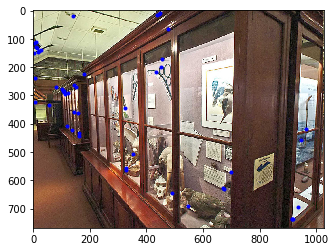

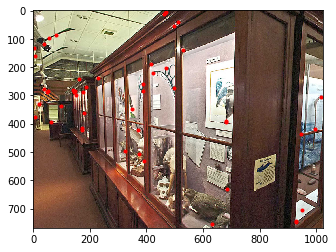

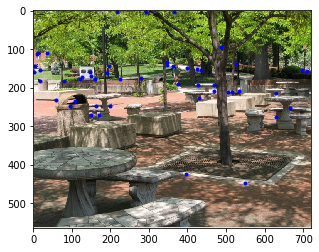

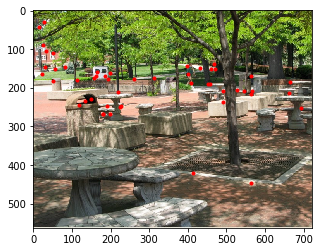

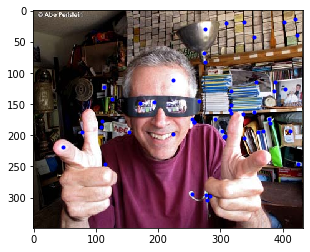

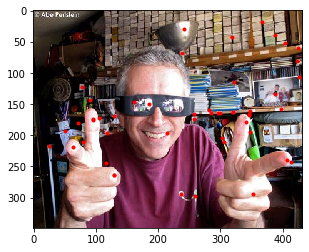

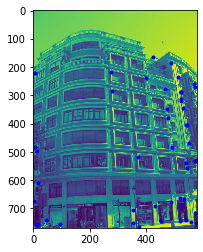

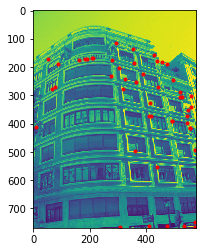

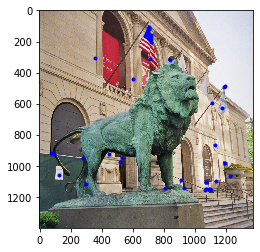

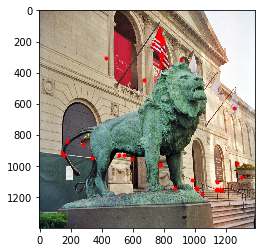

In [142]:
def plotFromC(c, idx, path, color):
    x_list = []
    y_list = []
    for i in range(len(c)):
        x_list.append(c[i][idx][0])
        y_list.append(c[i][idx][1])
    im = plt.imread(path)
    implot = plt.imshow(im)
    plt.plot(x_list, y_list, color)
    plt.show()

for k in range(5):
    plotFromC(ttl_C[k], 0, ttl_path_p[k], 'b.')
    plotFromC(ttl_C[k], 1, ttl_path_q[k], 'r.')

In [181]:
# compute C0
ttl_c0 = []
for j in range(5):
    c0 = []
    p = ttl_p[j]
    q = ttl_q[j]
    for i in range(len(p)):
        c0.append(([p[i][0], p[i][1], 1], [q[i][0], q[i][1], 1]))
#     print("C0:\n", c0)
    ttl_c0.append(c0)
ttl_c0

[[([81, 123, 1], [126, 131, 1]),
  ([594, 409, 1], [609, 412, 1]),
  ([848, 504, 1], [857, 508, 1]),
  ([167, 212, 1], [200, 216, 1]),
  ([983, 300, 1], [1017, 302, 1]),
  ([146, 581, 1], [177, 579, 1]),
  ([57, 482, 1], [97, 480, 1]),
  ([242, 494, 1], [268, 494, 1]),
  ([213, 56, 1], [251, 63, 1]),
  ([944, 639, 1], [966, 647, 1])],
 [([95, 303, 1], [118, 302, 1]),
  ([309, 433, 1], [318, 433, 1]),
  ([36, 176, 1], [70, 175, 1]),
  ([419, 192, 1], [451, 191, 1]),
  ([623, 451, 1], [639, 450, 1]),
  ([575, 224, 1], [605, 223, 1]),
  ([157, 176, 1], [192, 175, 1]),
  ([73, 536, 1], [72, 536, 1]),
  ([398, 75, 1], [418, 74, 1]),
  ([229, 145, 1], [265, 144, 1])],
 [([135, 50, 1], [100, 49, 1]),
  ([52, 253, 1], [58, 253, 1]),
  ([165, 164, 1], [159, 162, 1]),
  ([170, 28, 1], [135, 27, 1]),
  ([289, 78, 1], [255, 78, 1]),
  ([253, 293, 1], [236, 293, 1]),
  ([386, 112, 1], [351, 112, 1]),
  ([418, 11, 1], [383, 12, 1]),
  ([223, 197, 1], [215, 196, 1]),
  ([418, 211, 1], [383, 211, 1])]

In [86]:
fundamental.shape
fundamental[4,2]

tensor([[-1.7973e-07,  3.6116e-04,  1.7423e-01],
        [-3.6199e-04, -2.7434e-06, -2.6123e+00],
        [-1.7365e-01,  2.5793e+00,  1.0000e+00]])

In [174]:
torch.save(fundamental, "fundamental.pth")

selected point in image 1: [81, 123, 1]
mapped point in image 2: [126, 131, 1]
selected point in image 2: [268, 494, 1]
mapped point in image 2: [242, 494, 1]

Epipolar line for F0 1->2:  [ 8.09308391e-04 -1.40780015e-03  1.00000000e+00]
Epipolar line for F0 2->1:  [-1.76867990e-03  3.27039688e-04  1.00000000e+00]
Epipolar line for F1 1->2:  [-1.53898573e-03  8.88467621e-04  1.00000000e+00]
Epipolar line for F1 2->1:  [ 0.00604808 -0.00810254  1.        ]
Epipolar line for F2 1->2:  [ 0.00429132 -0.01183528  1.        ]
Epipolar line for F2 2->1:  [ 4.33297931e-04 -2.24881236e-03  1.00000000e+00]


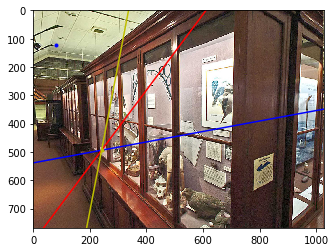

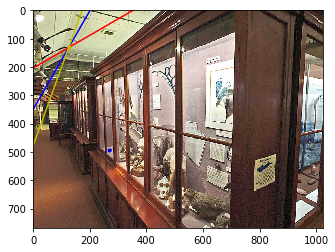

selected point in image 1: [95, 303, 1]
mapped point in image 2: [118, 302, 1]
selected point in image 2: [72, 536, 1]
mapped point in image 2: [73, 536, 1]

Epipolar line for F0 1->2:  [-1.18560218e-03  3.32089411e-04  1.00000000e+00]
Epipolar line for F0 2->1:  [ 8.46741228e-04 -7.16102082e-03  1.00000000e+00]
Epipolar line for F1 1->2:  [-2.09802261e-04 -9.67730983e-04  1.00000000e+00]
Epipolar line for F1 2->1:  [-0.01419827  0.03919217  1.        ]
Epipolar line for F2 1->2:  [ 2.12635155e-04 -3.39461825e-03  1.00000000e+00]
Epipolar line for F2 2->1:  [ 2.53170710e-04 -1.89626359e-03  1.00000000e+00]


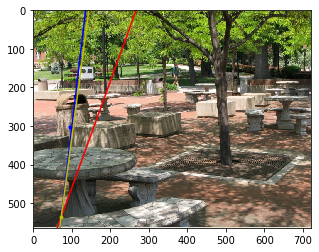

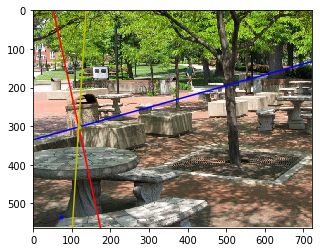

selected point in image 1: [135, 50, 1]
mapped point in image 2: [100, 49, 1]
selected point in image 2: [383, 12, 1]
mapped point in image 2: [418, 11, 1]

Epipolar line for F0 1->2:  [-1.40465858e-03  3.66756088e-04  1.00000000e+00]
Epipolar line for F0 2->1:  [-0.00245628 -0.00352483  1.        ]
Epipolar line for F1 1->2:  [-1.25086618e-03  2.29445641e-04  1.00000000e+00]
Epipolar line for F1 2->1:  [-0.0015086  -0.00448978  1.        ]
Epipolar line for F2 1->2:  [-8.93703011e-03  8.06262362e-04  1.00000000e+00]
Epipolar line for F2 2->1:  [-0.00214396 -0.00437825  1.        ]


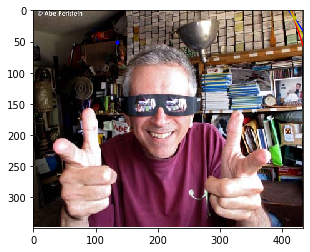

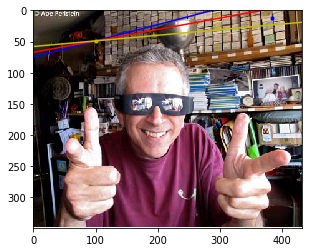

selected point in image 1: [22, 152, 1]
mapped point in image 2: [10, 163, 1]
selected point in image 2: [521, 149, 1]
mapped point in image 2: [479, 145, 1]

Epipolar line for F0 1->2:  [-1.36322800e-03  5.61535792e-04  1.00000000e+00]
Epipolar line for F0 2->1:  [-3.17883928e-04 -2.22674827e-03  1.00000000e+00]
Epipolar line for F1 1->2:  [-1.27083459e-03 -1.85611544e-04  1.00000000e+00]
Epipolar line for F1 2->1:  [-0.00331321  0.0019386   1.        ]
Epipolar line for F2 1->2:  [ 0.01344373 -0.00856776  1.        ]
Epipolar line for F2 2->1:  [-2.29624560e-03  5.58291045e-04  1.00000000e+00]


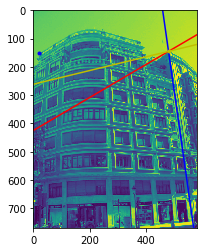

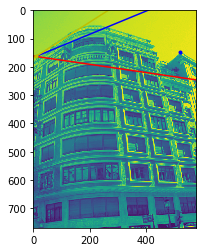

selected point in image 1: [96, 236, 1]
mapped point in image 2: [170, 239, 1]
selected point in image 2: [1266, 485, 1]
mapped point in image 2: [1192, 482, 1]

Epipolar line for F0 1->2:  [-1.11708205e-03 -7.34196987e-04  1.00000000e+00]
Epipolar line for F0 2->1:  [-1.60962361e-03  5.79987899e-04  1.00000000e+00]
Epipolar line for F1 1->2:  [-1.34522816e-03  2.29488451e-04  1.00000000e+00]
Epipolar line for F1 2->1:  [-1.55535730e-03  5.23739094e-04  1.00000000e+00]
Epipolar line for F2 1->2:  [ 4.37473094e-04 -4.46461853e-03  1.00000000e+00]
Epipolar line for F2 2->1:  [ 3.34264698e-04 -2.90336424e-03  1.00000000e+00]


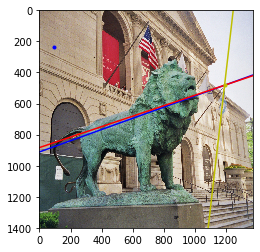

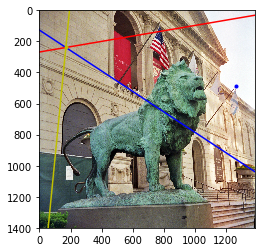

In [178]:
epipoles = torch.zeros(5,3,2,3)
for n_image in range(5):
    point_idx1 = 0
    point_idx2 = 7
    F0 = fundamental[n_image,0].numpy()
    F1 = fundamental[n_image,1].numpy()
    F2 = fundamental[n_image,2].numpy()
    c0 = ttl_c0[n_image]
    # select point in image 1
    point1 = c0[point_idx1][0]
    map_point1 = c0[point_idx1][1]
    print("selected point in image 1: {}\nmapped point in image 2: {}".format(point1, map_point1))
    # select point in image 2
    point2 = c0[point_idx2][1]
    map_point2 = c0[point_idx2][0]
    print("selected point in image 2: {}\nmapped point in image 2: {}".format(point2, map_point2))

    def compEpipolarLine(point, F, reverse):
        x = np.array(point)
        if reverse:
            l = np.matmul(np.transpose(F), x)
        else:
            l = np.matmul(F, x)
        l /= l[2]
        return l

    # epipolar line for F0
    l_F0_1 = compEpipolarLine(point1, F0, False)
    print("\nEpipolar line for F0 1->2: ", l_F0_1)
    l_F0_2 = compEpipolarLine(point2, F0, True)
    print("Epipolar line for F0 2->1: ", l_F0_2)
    # epipolar line for F1
    l_F1_1 = compEpipolarLine(point1, F1, False)
    print("Epipolar line for F1 1->2: ", l_F1_1)
    l_F1_2 = compEpipolarLine(point2, F1, True)
    print("Epipolar line for F1 2->1: ", l_F1_2)
    # epiploar line for F2
    l_F2_1 = compEpipolarLine(point1, F2, False)
    print("Epipolar line for F2 1->2: ", l_F2_1)
    l_F2_2 = compEpipolarLine(point2, F2, True)
    print("Epipolar line for F2 2->1: ", l_F2_2)
    l0 = torch.cat((torch.from_numpy(l_F0_1), torch.from_numpy(l_F0_2))).view(1,2,3)
    l1 = torch.cat((torch.from_numpy(l_F1_1), torch.from_numpy(l_F1_2))).view(1,2,3)
    l2 = torch.cat((torch.from_numpy(l_F2_1), torch.from_numpy(l_F2_2))).view(1,2,3)
    image_l = torch.cat((l0,l1,l2)).view(1,3,2,3)
    epipoles[n_image] = image_l
    
    
    def plotEpiLine(p_ori, p_map, path, l_1, l_2, l_3):
        im = plt.imread(path)
        implot = plt.imshow(im)
        plt.xlim(0, im.shape[1])
        plt.ylim(0, im.shape[0])
        plt.gca().invert_yaxis()
        plt.plot([p_map[0]-10000000*l_1[0], p_map[0]+10000000*l_1[0]], [p_map[1]-10000000*l_1[1], p_map[1]+10000000*l_1[1]], 'b')
        plt.plot([p_map[0]-10000000*l_2[0], p_map[0]+10000000*l_2[0]], [p_map[1]-10000000*l_2[1], p_map[1]+10000000*l_2[1]], 'r')
        plt.plot([p_map[0]-10000000*l_3[0], p_map[0]+10000000*l_3[0]], [p_map[1]-10000000*l_3[1], p_map[1]+10000000*l_3[1]], 'y')
        plt.plot(p_map[0], p_map[1], 'y.')
        plt.plot(p_ori[0], p_ori[1], 'b.')
        plt.show()
        return implot

    # plot in image1
    fig = plotEpiLine(point1, map_point2, path_p[n_image], l_F0_2, l_F1_2, l_F2_2)
    fig.figure.savefig(save + 'epipolar'+str(n_image+1)+'1.png')
    # plot in image2
    fig = plotEpiLine(point2, map_point1, path_q[n_image], l_F0_1, l_F1_1, l_F2_1)
    fig.figure.savefig(save + 'epipolar'+str(n_image+1)+'2.png')


In [176]:
epipoles.shape

torch.Size([5, 3, 2, 3])

In [177]:
torch.save(epipoles, "epipoles.pth")